# Transport patterns between curves
The goal of this notebook is to visualize transport patterns between
curves; it appears that the linear program may be the bottleneck of
the implementation, so we're going to see if we can write a more efficient
implementation here.

First, we'll define some curves.

In [196]:
# imports
import numpy as np
import numpy.linalg as la
import scipy.optimize as op
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt

%matplotlib inline

## Define (and plot) the line segments

/home/harrison/.local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



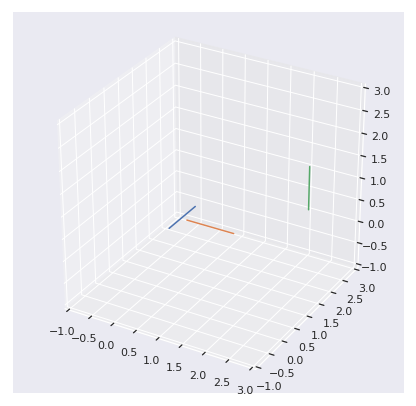

In [197]:
def line_segment(start, vec, seglen, n_pts):
    p0 = np.array(start)
    v = np.array(vec)
    v = v / la.norm(v) * seglen / n_pts
    return np.array([p0+k*v for k in range(n_pts+1)])

def random_uniform_direction():
    theta = np.random.uniform(0, 2*np.pi)
    z = np.random.uniform(-1,1)
    r = np.sqrt(1 - z*z) * np.random.choice([-1,1])
    return [r*np.cos(theta), r*np.sin(theta), z]

N_DIV = 31
N_CURVE = 3
RMAX = 2.

RND = False

if RND:
    curves = [
        line_segment(np.random.uniform(0, RMAX, size=3), 
                     random_uniform_direction(), 1, N_DIV-1),
        line_segment(np.random.uniform(0, RMAX, size=3), 
                     random_uniform_direction(), 1, N_DIV-1),
        line_segment(np.random.uniform(0, RMAX, size=3), 
                     random_uniform_direction(), 1, N_DIV-1)
    ]
else:
    curves = [
        line_segment((0,1,0), 
                     (0.001,1,0), 1, N_DIV-1),
        line_segment((1,0,1), 
                     (1,0,0), 1, N_DIV-1),
        line_segment((2,3,0), 
                     (0,0,1), 1, N_DIV-1)
    ]
    
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for curve in curves:
    ax.plot(*curve.T)
    
ax.set_xlim(-1,RMAX+1)
ax.set_ylim(-1,RMAX+1)
ax.set_zlim(-1,RMAX+1)
#ax.set_aspect(1.)

fig.show()

## Geometric median function

In [198]:
import numpy.linalg as la


def get_intersect_3d_many(S):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    """
    
    P1 = S[:,0]
    V1 = S[:,1] - P1
    V1 /= la.norm(V1, axis=1)[:,np.newaxis]
    P2 = S[:,2]
    V2 = S[:,3] - P2
    V2 /= la.norm(V2, axis=1)[:,np.newaxis]
    
    V3 = np.cross(V1, V2, axis=1)
    V3 /= la.norm(V3, axis=1)[:,np.newaxis]
    
    RHS = P2-P1
    LHS = np.stack([V1,-V2,V3], axis=2)
    #print(LHS.shape, RHS.shape)
    
    #x = la.tensorsolve(LHS, RHS)
    x = np.array([la.solve(A,b) for A,b in zip(LHS, RHS)])
    # x.shape is BATCH,(t1,t2,t3)
    #print(x)
    
    Q1 = P1 + x[:,[0]]*V1
    Q2 = P2 + x[:,[1]]*V2
    
    return (Q1+Q2)/2

## Set up the linear program

In [199]:
#%%timeit

import math, itertools

TH60 = np.radians(30)
C60 = np.cos(TH60)
S60 = np.sin(TH60)

def f():
# Specific 3-group case
    groups = {'index': [], 'median': [], 'energy': []}
    
    for i0, A in enumerate(curves[0]):
        K = len(curves[0])
        
        # matrix of angles
        # phimtx = Betamtx[i0,:] - Gammamtx[i0,:,np.newaxis]
        # pmamtx = (1.*(phimtx < 0))[:,:,np.newaxis]
        
        # Get vectors stemming from A
        AB = np.broadcast_to((curves[1] - A)[:,np.newaxis], (K,K,3))
        AC = np.broadcast_to((curves[2] - A)[np.newaxis], (K,K,3))
        
        # Get orientation of AB, AC:
        # print(1.*(np.cross(AB, AC, axis=2) < 0)) # actually I don't need this
        
        # Get GS of AC to get perp to AB
        AB_perpC = (AC - (np.sum(AC*AB, axis=2)/la.norm(AB, axis=2)**2)[:,:,np.newaxis] * AB)
        AB_perpC /= (la.norm(AB_perpC, axis=2)/la.norm(AB, axis=2))[:,:,np.newaxis] # normalize
        
        # Get GS of AB to get perp to AC
        AC_perpB = (AB - (np.sum(AC*AB, axis=2)/la.norm(AC, axis=2)**2)[:,:,np.newaxis] * AC)
        AC_perpB /= (la.norm(AC_perpB, axis=2)/la.norm(AC, axis=2))[:,:,np.newaxis] # normalize
        
        # compute points R and Q
        RR = A + S60*AB - C60*AB_perpC
        QQ = A + S60*AC - C60*AC_perpB
        
        AA = np.broadcast_to(A, (K,K,3))
        BB = np.broadcast_to(curves[1][:,np.newaxis], (K,K,3))
        CC = np.broadcast_to(curves[2][np.newaxis], (K,K,3))

        index = itertools.product([i0], range(K), range(K))
                
        Batch = np.stack([RR,CC,QQ,BB], axis=2)
        batch = np.reshape(Batch, (K*K, 4, 3))
        
        Pvec = get_intersect_3d_many(batch)
            
        Sb = np.zeros((batch.shape[0], 4, 3))
        Sb[:,0] = A
        Sb[:,1] = batch[:,3]
        Sb[:,2] = batch[:,1]
        Sb[:,3] = Pvec

        Zb = Sb[:,0:3,:]

        Evec = np.sum(
            la.norm(Sb[:,:,np.newaxis]-Zb[:,np.newaxis], axis=-1),
            axis=2
        )

        minvec = 3*np.ones((K*K),dtype='int32')#np.argmin(Evec, axis=1)
        
        Energy = np.take_along_axis(Evec, minvec[:,np.newaxis], 1).flatten()
        Median = np.take_along_axis(Sb, minvec[:,np.newaxis,np.newaxis], 1).reshape(K*K,3)
        
        groups['index'].extend(index)
        groups['median'].extend(Median)
        groups['energy'].extend(Energy)

    return groups

groups = f()

In [200]:
medians = np.array(groups['median'])

In [201]:
#pd.DataFrame(groups)

We now move on to setting up (and solving) the linear program proper. Scipy's linprog uses the following form for linear programs. We are solving for \\(x\\) which minimizes
\\[ c^T x \\]
while satisfying the constraints
\\[ A_{ub} x \le b_{ub}, \quad A_{eq} x = b_{eq}, \quad l \le x \le u \\]

In our case, the cost we're minimizing is the linear combination of total median distances

In [202]:
# group energies (c-vector)
energies = np.array(groups['energy'])

In [203]:
def _idxs(index):
    return [i*N_DIV+j for i,j in enumerate(index)]

import scipy.sparse as sparse
from scipy import stats

def eq_constraints():
    II = np.array(groups['index'])
    II[:,1] += N_DIV
    II[:,2] += 2*N_DIV
    
    # equality constraints
    #A_eq = np.zeros((N_DIV*N_CURVE, len(energies)))
    A_eq = sparse.dok_matrix((N_DIV*N_CURVE, len(energies)))
    
    #print(A_eq.shape, II.shape)
    np.put_along_axis(A_eq, II.T, np.ones((3, len(energies))), 0)
    
    #for i,j in enumerate(II):
    #    A_eq[j, i] = 1.
        
    # transport quantities are all 1 for uniform problem
    b_eq = np.ones(A_eq.shape[0])/N_DIV
    
    # transport quantities for normal distribution
    #norm = stats.norm()
    #b_eq = np.concatenate(
    #    [norm.pdf(np.linspace(-5,5,N_DIV)) for _ in range(N_CURVE)]
    #)
    
    return A_eq, b_eq

In [204]:
A_eq, b_eq = eq_constraints()

In [205]:
import numpy as np
solver = 'scipy-interior-point'

def lpsolve(energies, A_eq, b_eq):
    if solver == 'scipy-interior-point':
        from scipy.optimize import linprog
        soln = linprog(energies, A_eq=A_eq, b_eq=b_eq, method='interior-point')
        return soln
    else:
        from orwrap import Solver

        lp = Solver('TransportPlan', Solver.GLOP_LINEAR_PROGRAMMING)

        var = lp.NumVarDict(range(A_eq.shape[1]), 0, 1, "x")
        
        lp.MakeMatrixConstraint(
            A_eq, 
            var,
            b_eq, b_eq)
        
        obj = lp.Objective()
        for v,e in zip(var.values(), energies):
            obj.SetCoefficient(v, e)
        obj.SetMinimization()
        
        lp.Solve()
        return var
                
    return soln
    
#soln = linprog(energies, A_eq=A_eq, b_eq=b_eq, method='revised simplex')

In [206]:
%%time

soln=lpsolve(energies, A_eq, b_eq)

/home/harrison/.local/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:2050: OptimizeWarning:

Sparse constraint matrix detected; setting 'sparse':True.



CPU times: user 809 ms, sys: 175 ms, total: 985 ms
Wall time: 683 ms


/home/harrison/.local/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:623: OptimizeWarning:

A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.



In [207]:
import pandas as pd
solution = pd.DataFrame([
    {'weight': x, 
     'median_x': m[0], 
     'median_y': m[1],
     'median_z': m[2],
     't_0': j[0],
     't_1': j[1],
     't_2': j[2]} for 
    x,(m,j) in zip(soln['x'], zip(groups['median'], groups['index']))])

print(len(solution[solution['weight'] > 0.001]), "median points")
solution[solution['weight'] > 0.001].sort_values('t_2')

31 median points


,median_x,median_y,median_z,t_0,t_1,t_2,weight
5766,0.563388,1.183719,0.249154,6,0,0,0.032258
6759,0.588154,1.212315,0.257283,7,1,1,0.032258
7752,0.613023,1.240811,0.265604,8,2,2,0.032258
11814,0.756085,1.365800,0.282618,12,9,3,0.032258
12807,0.780898,1.394487,0.291195,13,10,4,0.032258
15815,0.864214,1.486041,0.301073,16,14,5,0.032258
18792,0.929284,1.574058,0.309379,19,17,6,0.032258
20808,0.991748,1.637116,0.320377,21,20,7,0.032258
22793,1.036676,1.695701,0.330711,23,22,8,0.032258
24809,1.097950,1.759692,0.342944,25,25,9,0.032258


/home/harrison/.local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



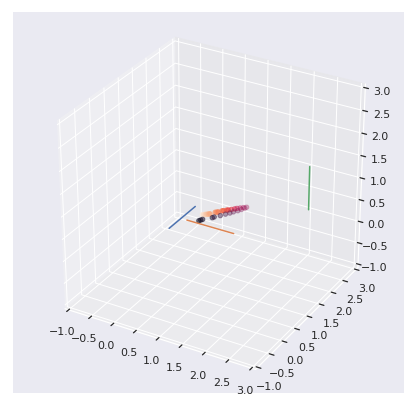

In [208]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for curve in curves:
    ax.plot(*curve.T)
    
sdf = solution[solution['weight'] > 1e-3]
ax.scatter(sdf['median_x'], sdf['median_y'], sdf['median_z'], c=sdf['t_2'])
    
ax.set_xlim(-1,RMAX+1)
ax.set_ylim(-1,RMAX+1)
ax.set_zlim(-1,RMAX+1)
#ax.set_aspect(1.)

fig.show()

/home/harrison/.local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



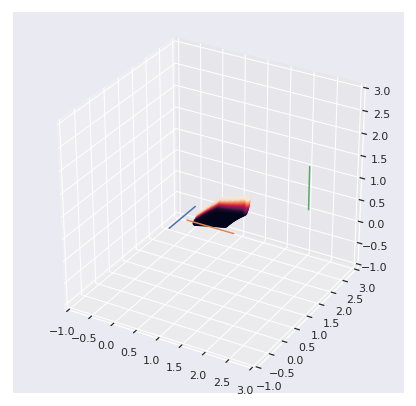

In [209]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for curve in curves:
    ax.plot(*curve.T)
    
sdf = solution
ax.scatter(sdf['median_x'], sdf['median_y'], sdf['median_z'], c=sdf['t_2'])
    
ax.set_xlim(-1,RMAX+1)
ax.set_ylim(-1,RMAX+1)
ax.set_zlim(-1,RMAX+1)
#ax.set_aspect(1.)

fig.show()

In [210]:
import plotly as py
import plotly.graph_objects as go
import numpy as np

data = []
for i in range(0,N_DIV,5):
    continue
    sdf = solution[(solution['t_0'] == i) & (solution['t_1']%5 == 0) & (solution['t_2']%5 == 0)]
    sdf = sdf.pivot_table(values=['median_x', 'median_y', 'median_z'], index='t_1', columns='t_2')

    surface = go.Surface(x=sdf['median_x'], y=sdf['median_y'], z=sdf['median_z'], opacity=0.75, showscale=False, hoverinfo="skip")
    """surface = go.Scatter3d(x=sdf['median_x'], y=sdf['median_y'], z=sdf['median_z'], 
                           mode='markers',
                           marker=dict(
                               color=sdf['t_2'],
                               colorscale='Viridis',
                               opacity=0.8
                           ))"""

    data.append(surface)

for curve in curves:
    c = curve[::5]
    data.append(go.Scatter3d(x=c[:,0], y=c[:,1], z=c[:,2],
                             mode='lines',
                            marker=None, line=dict(color='darkblue', width=2)))
    
ans = solution[solution['weight'] > 1e-3]

data.append(go.Scatter3d(x=ans['median_x'], y=ans['median_y'], z=ans['median_z'],
                        mode='markers', marker=dict(
                            size=50*ans['weight']/max(ans['weight']),
                            color=np.arange(len(ans)),
                        colorscale='Viridis')))
    
layout = go.Layout(
    title='Solution in Euclidean space',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
fig.update_layout(showlegend=False)
py.offline.iplot(fig, filename='jupyter-parametric_plot')

In [211]:
import plotly as py
import plotly.graph_objects as go
import numpy as np

data = []

ans = solution[solution['weight'] > 1e-3]

data.append(go.Scatter3d(x=ans['t_0'], y=ans['t_1'], z=ans['t_2'],
                        mode='markers', marker=dict(
                            size=10*ans['weight']/max(ans['weight']),
                            color=np.arange(len(ans)),
                        colorscale='Viridis')))
    
layout = go.Layout(
    title='Solution as submanifold of interval product',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
fig.update_layout(showlegend=False)
py.offline.iplot(fig, filename='jupyter-parametric_plot')

In [212]:
from scipy import stats
stats.norm(1.*5).pdf(2)

0.0044318484119380075

In [213]:
A_eq.shape[0]

93